**install library**

In [1]:
!pip install sentence-transformers pandas numpy scikit-learn matplotlib

In [2]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# import dataset
news_data = pd.read_csv('bbc_news.csv')
df = news_data.copy()

# data preparation
titles = df['title'].astype(str)

print(f"Total titles to process: {len(titles)}")

# แปลง text ให้เป็น vector ด้วย Sentence-Transformers
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
print(f"Loading and encoding titles using {model_name}...")

# สร้าง dense vector matrix
embeddings = model.encode(titles.tolist(), show_progress_bar=True)
print(f"Shape of Embeddings matrix: {embeddings.shape}")

Total titles to process: 42115


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading and encoding titles using all-MiniLM-L6-v2...


Batches:   0%|          | 0/1317 [00:00<?, ?it/s]

Shape of Embeddings matrix: (42115, 384)


**Find Optimal K for K-Means**

Testing K from 2 to 20
k= 2 -> inertia=38120.87, silhouette=0.0429, CH=1119.91
k= 3 -> inertia=37382.13, silhouette=0.0405, CH=987.12
k= 4 -> inertia=36781.19, silhouette=0.0504, CH=898.10
k= 5 -> inertia=36347.33, silhouette=0.0542, CH=807.23
k= 6 -> inertia=35972.89, silhouette=0.0497, CH=740.19
k= 7 -> inertia=35625.76, silhouette=0.0530, CH=691.22
k= 8 -> inertia=35319.28, silhouette=0.0572, CH=649.77
k= 9 -> inertia=35040.56, silhouette=0.0512, CH=614.91
k=10 -> inertia=34824.18, silhouette=0.0529, CH=579.05
k=11 -> inertia=34635.79, silhouette=0.0555, CH=546.88
k=12 -> inertia=34448.53, silhouette=0.0551, CH=520.68
k=13 -> inertia=34280.50, silhouette=0.0571, CH=496.81
k=14 -> inertia=34136.76, silhouette=0.0587, CH=474.13
k=15 -> inertia=34011.31, silhouette=0.0602, CH=452.98
k=16 -> inertia=33888.64, silhouette=0.0614, CH=434.46
k=17 -> inertia=33775.05, silhouette=0.0616, CH=417.51
k=18 -> inertia=33667.94, silhouette=0.0590, CH=402.08
k=19 -> inertia=33567.55, silhouette=0.05

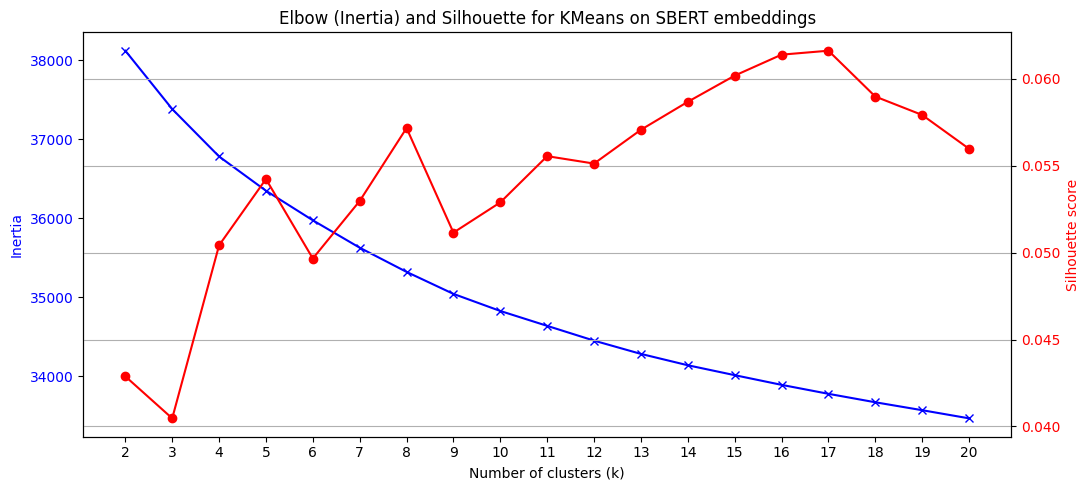


Top candidate k by Silhouette (best -> worse):
  k=17 : silhouette=0.0616, inertia=33775.05, CH=417.51
  k=16 : silhouette=0.0614, inertia=33888.64, CH=434.46
  k=15 : silhouette=0.0602, inertia=34011.31, CH=452.98

👉 Chosen optimal_k = 17 (by silhouette max).
Silhouette Score (KMeans with k=17): 0.0616


In [3]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETERS
K_min = 2
K_max = 20
K_range = range(K_min, K_max + 1)
# ---------------------------

inertia_values = []
silhouette_values = []
ch_scores = []

print("Testing K from", K_min, "to", K_max)
for k in K_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_model.fit_predict(embeddings)
    inertia = kmeans_model.inertia_
    inertia_values.append(inertia)

    # silhouette requires at least 2 clusters and < n_samples clusters
    try:
        sil = silhouette_score(embeddings, labels, metric='cosine')  # cosine works fine for SBERT
    except Exception:
        sil = np.nan
    silhouette_values.append(sil)

    # Calinski-Harabasz (alternative metric)
    try:
        ch = calinski_harabasz_score(embeddings, labels)
    except Exception:
        ch = np.nan
    ch_scores.append(ch)

    print(f"k={k:2d} -> inertia={inertia:.2f}, silhouette={sil:.4f}, CH={ch:.2f}")

# Plot both inertia and silhouette
fig, ax1 = plt.subplots(figsize=(11,5))
ax1.plot(list(K_range), inertia_values, 'bx-', label='Inertia (Elbow)')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(list(K_range))

ax2 = ax1.twinx()
ax2.plot(list(K_range), silhouette_values, 'ro-', label='Silhouette')
ax2.set_ylabel('Silhouette score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Elbow (Inertia) and Silhouette for KMeans on SBERT embeddings')
fig.tight_layout()
plt.grid(True)
plt.show()

# Choose best k by silhouette (primary)
sil_array = np.array(silhouette_values, dtype=np.float64)
# ignore NaN when choosing
if np.all(np.isnan(sil_array)):
    # fallback: choose elbow by largest relative drop in inertia
    print("Silhouette scores all NaN. Falling back to elbow heuristic.")
    # compute relative drops of inertia
    rel_drop = np.diff(inertia_values) / np.array(inertia_values[:-1])
    elbow_idx = np.argmin(rel_drop)  # biggest negative drop -> min relative diff
    optimal_k = list(K_range)[elbow_idx + 1]  # +1 because diff reduces length by 1
else:
    best_idx = int(np.nanargmax(sil_array))
    optimal_k = list(K_range)[best_idx]

# Tie-break / sanity: if silhouette peak is at very large k near K_max, optionally pick local peak
# find top 3 k by silhouette to show
top_k_idx = np.argsort(np.nan_to_num(sil_array, nan=-999))[::-1][:3]
top_k = [list(K_range)[i] for i in top_k_idx]

print("\nTop candidate k by Silhouette (best -> worse):")
for i in top_k_idx:
    k = list(K_range)[i]
    print(f"  k={k:2d} : silhouette={sil_array[i]:.4f}, inertia={inertia_values[i]:.2f}, CH={ch_scores[i]:.2f}")

print(f"\n👉 Chosen optimal_k = {optimal_k} (by silhouette max).")

# optional: small sanity check - don't pick k too close to number of samples
n_samples = embeddings.shape[0]
if optimal_k >= n_samples / 2:
    print("Warning: chosen k is large relative to sample size; consider reducing K_max or checking silhouette plot.")

# now you can continue with your KMeans run:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(embeddings)
silhouette_avg_kmeans = silhouette_score(embeddings, df['kmeans_cluster'], metric='cosine')
print(f"Silhouette Score (KMeans with k={optimal_k}): {silhouette_avg_kmeans:.4f}")


**K-Means Clustering**

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import umap.umap_ as umap

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df['kmeans_cluster'] = kmeans.fit_predict(embeddings)
sil_kmeans = silhouette_score(embeddings, df['kmeans_cluster'], metric='cosine')
print(f"KMeans silhouette (k={optimal_k}): {sil_kmeans:.4f}")

# 2D projection (UMAP preferred, fallback to t-SNE)
def reduce_to_2d(emb, n_neighbors=15, min_dist=0.1, random_state=42):
    try:
        reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
        emb2 = reducer.fit_transform(emb)
        print("Projection: UMAP used.")
    except Exception as e:
        print("UMAP failed or not installed:", e)
        print("Falling back to t-SNE (could be slower).")
        emb2 = TSNE(n_components=2, random_state=random_state, perplexity=30, n_iter=1000).fit_transform(emb)
    return emb2

emb2d = reduce_to_2d(embeddings)
df['emb2d_x'] = emb2d[:,0]
df['emb2d_y'] = emb2d[:,1]

# Keyword extraction per cluster (TF-IDF aggregated)
def compute_top_terms(titles, labels, top_n=12, stop_words='english'):
    vect = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words, min_df=2, max_df=0.9)
    X = vect.fit_transform(titles)
    feature_names = np.array(vect.get_feature_names_out())
    unique_labels = np.unique(labels)
    cluster_terms = {}
    for lb in unique_labels:
        idx = np.where(labels == lb)[0]
        if len(idx) == 0:
            cluster_terms[lb] = []
            continue
        summed = X[idx].sum(axis=0)
        arr = np.asarray(summed).squeeze()
        top_idx = arr.argsort()[::-1][:top_n]
        terms = [(feature_names[i], float(arr[i])) for i in top_idx]
        cluster_terms[lb] = terms
    return cluster_terms

titles_list = df['title'].astype(str).tolist()
kmeans_terms = compute_top_terms(titles_list, df['kmeans_cluster'].values, top_n=12)


KMeans silhouette (k=17): 0.0616


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Projection: UMAP used.


**Visualization function : scatter, bars, wordcloud**

In [10]:
from matplotlib import cm
import math
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_2d_scatter(df_plot, label_col, title):
    labels = df_plot[label_col].values
    unique_labels = np.unique(labels)
    plt.figure(figsize=(9,6))
    cmap = cm.get_cmap('tab20', len(unique_labels))
    for i, lb in enumerate(unique_labels):
        mask = labels == lb
        color = 'lightgray' if lb == -1 else cmap(i)
        lbl = 'noise' if lb == -1 else f'cluster {lb}'
        plt.scatter(df_plot.loc[mask, 'emb2d_x'], df_plot.loc[mask, 'emb2d_y'],
                    s=12, alpha=0.7, color=color, label=lbl)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_cluster_bars(cluster_terms, top_n=8, title_prefix=""):
    n = len(cluster_terms)
    cols = 3
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols*4, rows*3))
    i = 1
    for lb, terms_scores in sorted(cluster_terms.items(), key=lambda x: (x[0] if x[0] != -1 else 999)):
        terms = [t for t,s in terms_scores[:top_n]][::-1]
        scores = [s for t,s in terms_scores[:top_n]][::-1]
        plt.subplot(rows, cols, i)
        plt.barh(range(len(terms)), scores, align='center')
        plt.yticks(range(len(terms)), terms)
        plt.xlabel("TF-IDF sum")
        plt.title(f"{title_prefix} Cluster {lb}" if lb != -1 else f"{title_prefix} Noise (-1)")
        i += 1
    plt.tight_layout()
    plt.show()

def plot_cluster_wordclouds(cluster_terms, title_prefix="", max_words=50):
    n = len(cluster_terms)
    cols = 3
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols*4, rows*3))
    i = 1
    for lb, terms_scores in sorted(cluster_terms.items(), key=lambda x: (x[0] if x[0] != -1 else 999)):
        freq = {t: float(s) for t,s in terms_scores}
        plt.subplot(rows, cols, i)
        if len(freq) == 0:
            plt.text(0.5, 0.5, "No terms", ha='center')
        else:
            wc = WordCloud(background_color='white', width=400, height=250, max_words=max_words).generate_from_frequencies(freq)
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
        plt.title(f"{title_prefix} Cluster {lb}" if lb != -1 else f"{title_prefix} Noise (-1)")
        i += 1
    plt.tight_layout()
    plt.show()


**Visualization**


--- Visualization: KMeans ---


/tmp/ipython-input-947079735.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))


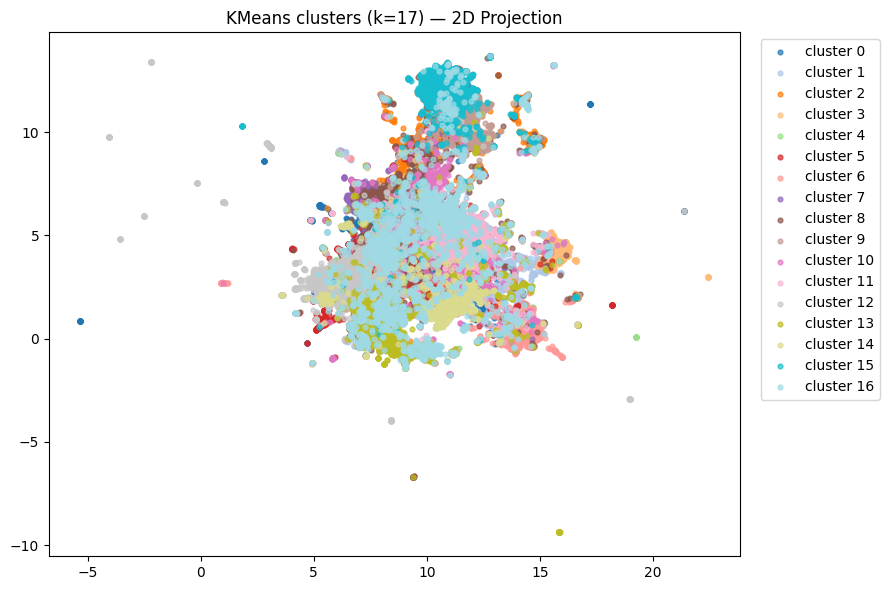

In [11]:
print("\n--- Visualization: KMeans ---")
plot_2d_scatter(df, 'kmeans_cluster', f"KMeans clusters (k={optimal_k}) — 2D Projection")


Top terms per KMeans cluster (TF-IDF aggregated):


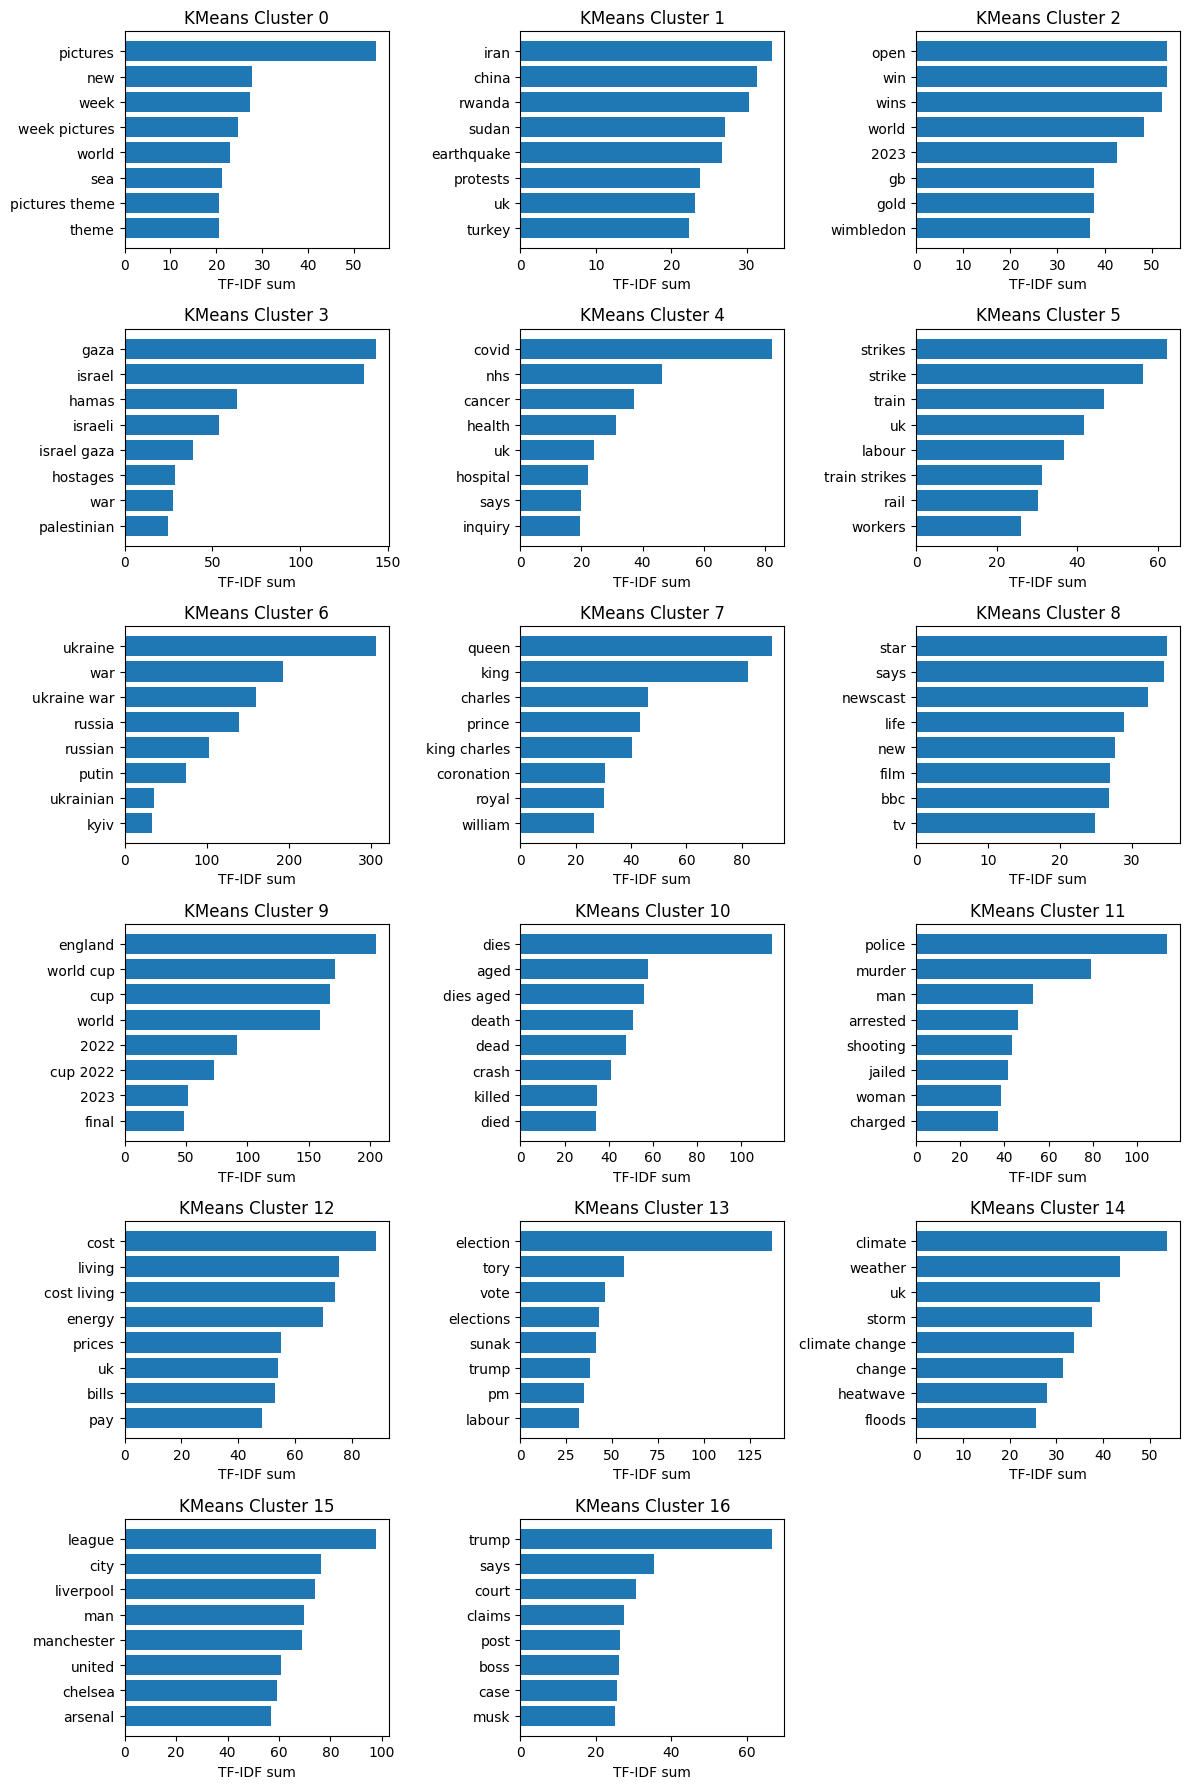

In [12]:
print("Top terms per KMeans cluster (TF-IDF aggregated):")
plot_cluster_bars(kmeans_terms, top_n=8, title_prefix="KMeans")

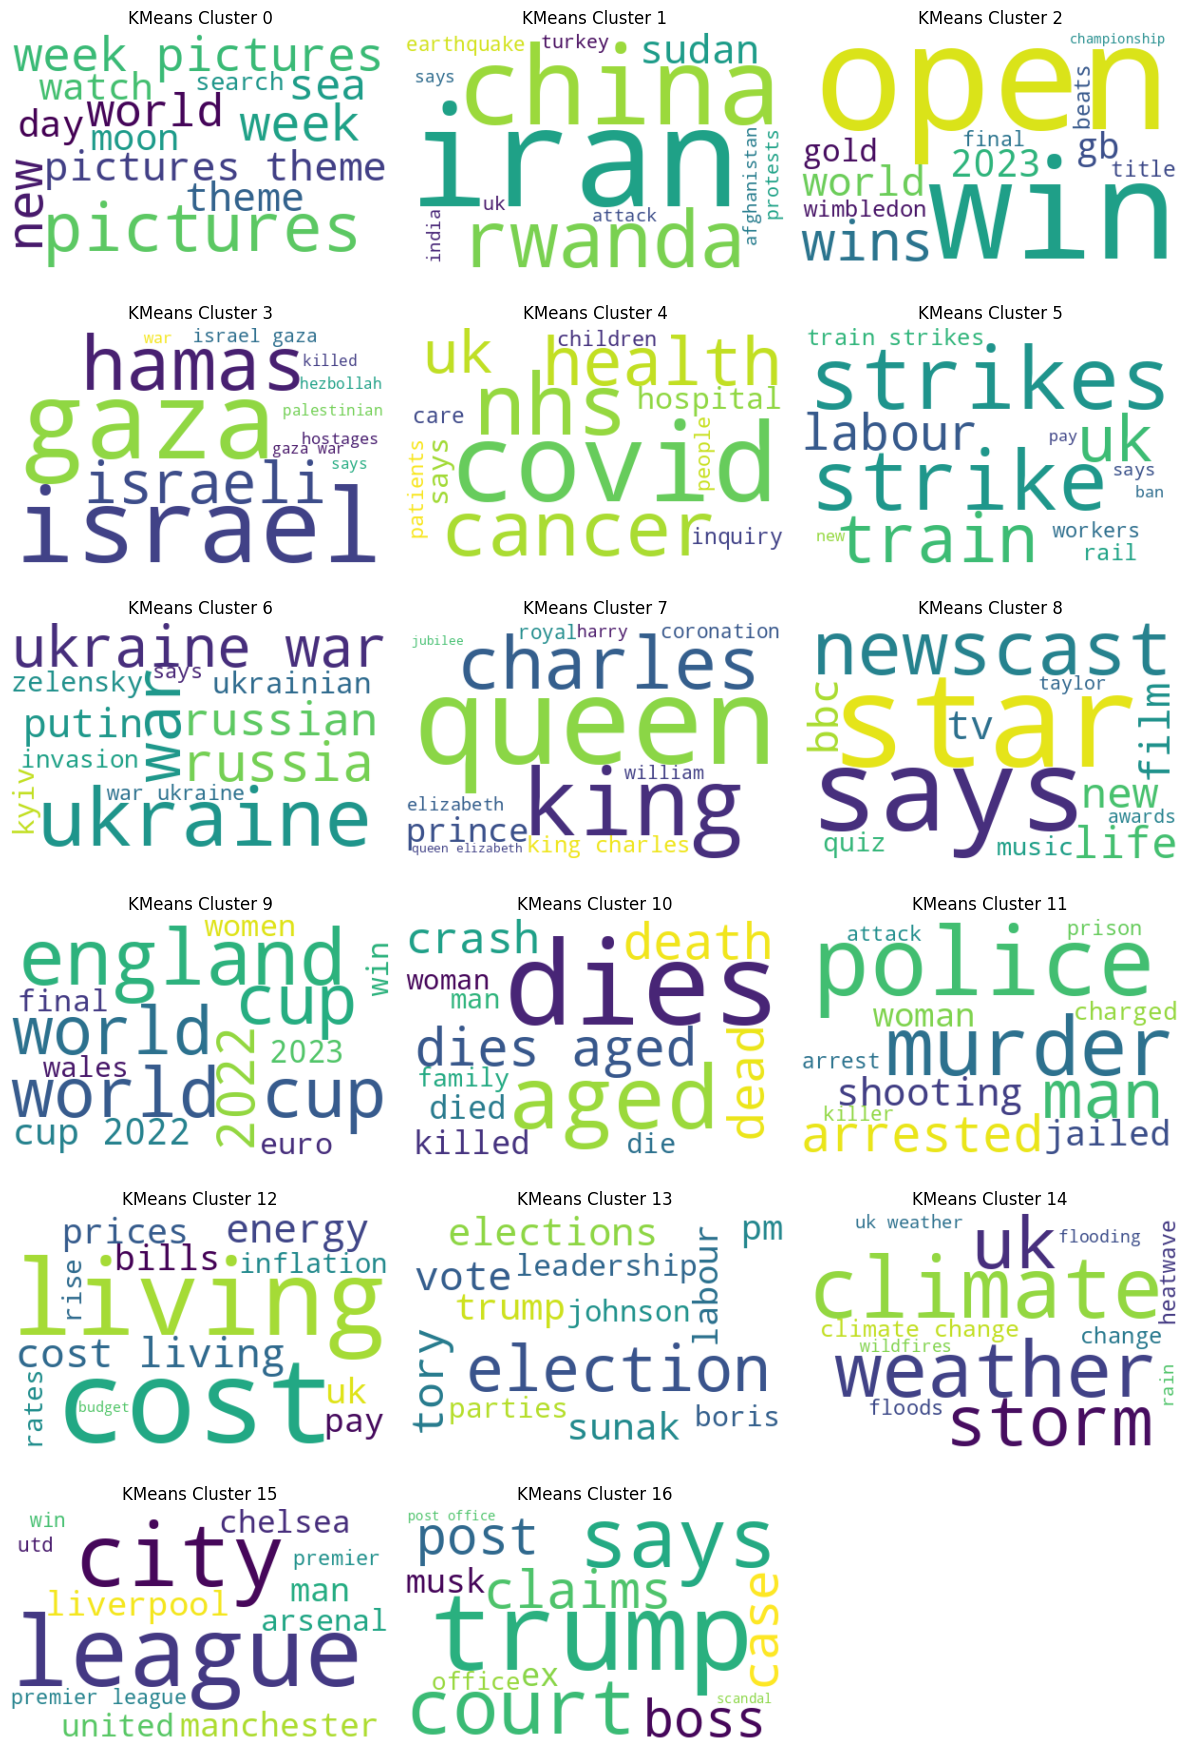

In [13]:
try:
    plot_cluster_wordclouds(kmeans_terms, title_prefix="KMeans", max_words=40)
except Exception as e:
    print("WordCloud error (install wordcloud?):", e)

In [14]:
# print summary table for KMeans
summary_k = []
for lb in sorted(np.unique(df['kmeans_cluster'])):
    cnt = int((df['kmeans_cluster']==lb).sum())
    top5 = [t for t,s in kmeans_terms.get(lb, [])[:5]]
    summary_k.append({'cluster': lb, 'count': cnt, 'top5': ', '.join(top5)})
print(pd.DataFrame(summary_k).to_markdown(index=False))

|   cluster |   count | top5                                        |
|----------:|--------:|:--------------------------------------------|
|         0 |    3009 | pictures, new, week, week pictures, world   |
|         1 |    2467 | iran, china, rwanda, sudan, earthquake      |
|         2 |    2691 | open, win, wins, world, 2023                |
|         3 |    1397 | gaza, israel, hamas, israeli, israel gaza   |
|         4 |    2012 | covid, nhs, cancer, health, uk              |
|         5 |    2320 | strikes, strike, train, uk, labour          |
|         6 |    2393 | ukraine, war, ukraine war, russia, russian  |
|         7 |    1256 | queen, king, charles, prince, king charles  |
|         8 |    4020 | star, says, newscast, life, new             |
|         9 |    2688 | england, world cup, cup, world, 2022        |
|        10 |    2217 | dies, aged, dies aged, death, dead          |
|        11 |    2854 | police, murder, man, arrested, shooting     |
|        12 |    289